# Проект 4 - Исследование тарифных планов оператора сотовой связи

## Введение

**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

Нам надо описать поведение клиентов оператора, исходя из выборки и проверить две гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
2. Средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

**Описание тарифов**

1. Тариф «Смарт»:
    - Ежемесячная плата: 550 рублей.
    - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика/
    - Стоимость услуг сверх тарифного пакета:
        - минута разговора: 3 рубля,
        - сообщение: 3 рубля,
        - 1 Гб интернет-трафика: 200 рублей.
2. Тариф «Ультра»:
    - Ежемесячная плата: 1950 рублей.
    - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.
    - Стоимость услуг сверх тарифного пакета:
        - минута разговора: 1 рубль,
        - сообщение: 1 рубль,
        - 1 Гб интернет-трафика: 150 рублей.

**Описание данных**

1. Таблица `users` (информация о пользователях):
    1. `user_id` — уникальный идентификатор пользователя.
    2. `first_name` — имя пользователя.
    3. `last_name` — фамилия пользователя.
    4. `age` — возраст пользователя (годы).
    5. `reg_date` — дата подключения тарифа (день, месяц, год).
    6. `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).
    7. `city` — город проживания пользователя.
    8. `tarif` — название тарифного плана.
2. Таблица `calls` (информация о звонках):
    1. `id` — уникальный номер звонка.
    2. `call_date` — дата звонка.
    3. `duration` — длительность звонка в минутах.
    4. `user_id` — идентификатор пользователя, сделавшего звонок.
3. Таблица `messages` (информация о сообщениях):
    1. `id` — уникальный номер сообщения
    2. `message_date` — дата сообщения
    3. `user_id` — идентификатор пользователя, отправившего сообщение
4. Таблица `internet` (информация об интернет-сессиях):
    1. `id` — уникальный номер сессии
    2. `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
    3. `session_date` — дата интернет-сессии
    4. `user_id` — идентификатор пользователя
5. Таблица `tariffs` (информация о тарифах):
    1. `tariff_name` — название тарифа
    2. `rub_monthly_fee` — ежемесячная абонентская плата в рублях
    3. `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
    4. `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
    5. `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    6. `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    7. `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
    8. `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Простые артефакты
2. Пропущенные значения и типы данных
3. Дополнительные параметры

Пойдем по порядку.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from IPython.display import display
plt.style.use('default')

# Я привык сохранять исходный датасет, чтобы можно было проследить какие преобразования были совершены.
raw_calls = pd.read_csv('calls.csv')
raw_internet = pd.read_csv('internet.csv')
raw_messages = pd.read_csv('messages.csv')
raw_tariffs = pd.read_csv('tariffs.csv')
raw_users = pd.read_csv('users.csv')

# Проверим, что внутри каждого датасета.
# raw_tarrifs можно проверить глазами, поэтому его опустим
for data in [raw_calls, raw_internet, raw_messages, raw_users]:
    data.info()
    print('-' * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
--------------------------------------------------


Хорошие новости: все датафреймы относительно простые и содержат по одному "смысловому" параметру. У нас также нет пропущенных строк, кроме столбца `churn_date` в датасете `raw_users`. Но для этой колонки, пропущенные строки, скорей всего, означают, что пользователь все еще пользуется нашими услугами.

У нас есть какая-то странная колонка `Unnamed: 0` в датасете `raw_internet`. Похоже, что она дублирует колонку `index`. Убьем ее за ненадобностью.

Также, нам надо будет правильно задать типы данных в этих датасетах.

Посмотрим, как распределны значения в этих датасетах.

In [2]:
# Проверим, что внутри каждого датасета.
# raw_messages также опустим, потому что там просто перечисление всех отправленных пользователем сообщений.
for data in [raw_calls, raw_internet, raw_users]:
    display(round(data.describe()))
    print('-' * 50)

,duration,user_id
count,202607.0,202607.0
mean,7.0,1254.0
std,6.0,145.0
min,0.0,1000.0
25%,1.0,1126.0
50%,6.0,1260.0
75%,11.0,1379.0
max,38.0,1499.0


--------------------------------------------------


,Unnamed: 0,mb_used,user_id
count,149396.0,149396.0,149396.0
mean,74698.0,370.0,1252.0
std,43127.0,278.0,144.0
min,0.0,0.0,1000.0
25%,37349.0,138.0,1130.0
50%,74698.0,348.0,1251.0
75%,112046.0,560.0,1380.0
max,149395.0,1725.0,1499.0


--------------------------------------------------


,user_id,age
count,500.0,500.0
mean,1250.0,47.0
std,144.0,17.0
min,1000.0,18.0
25%,1125.0,32.0
50%,1250.0,46.0
75%,1374.0,62.0
max,1499.0,75.0


--------------------------------------------------


В целом, все значения выглядят адекватно: пользователи разговаривают адекватное количество времени, используют нормальное количество трафика, а также в целом выглядят правдоподобными (возраст от 18 до 75 лет).

In [3]:
# Уберем колонку
raw_internet.drop('Unnamed: 0', axis=1, inplace=True)

# Причешем типы данных
raw_calls = raw_calls.astype({'id': 'object',
                              'call_date': 'datetime64',
                              'duration': 'float64',
                              'user_id': 'object'})

raw_internet = raw_internet.astype({'id': 'object',
                                    'mb_used': 'float64',
                                    'session_date': 'datetime64',
                                    'user_id': 'object'})

raw_messages = raw_messages.astype({'id': 'object',
                                    'message_date': 'datetime64',
                                    'user_id': 'object'})

raw_tariffs = raw_tariffs.astype({'messages_included': 'int64',
                                  'mb_per_month_included': 'int64',
                                  'minutes_included': 'int64',
                                  'rub_monthly_fee': 'int64',
                                  'rub_per_gb': 'int64',
                                  'rub_per_message': 'int64',
                                  'rub_per_minute': 'int64',
                                  'tariff_name': 'object'})

raw_users = raw_users.astype({'user_id': 'object',
                              'age': 'int64',
                              'churn_date': 'datetime64',
                              'city': 'object',
                              'first_name': 'object',
                              'last_name': 'object',
                              'reg_date': 'datetime64',
                              'tariff': 'object'})

Последним шагом создадим нужный нам датасет из уже существующих. Для этого воспользуемся сводными таблицами и функцией `join` / `merge`. Наша цель - получить основные показатели (например, количество потраченных минут в месяц) для каждого пользователя - `user_id` и каждого месяца 2018 года.

In [4]:
# Добавим колонку с месяцем к каждому датасету
raw_calls['month'] = raw_calls.call_date.dt.month
raw_messages['month'] = raw_messages.message_date.dt.month
raw_internet['month'] = raw_internet.session_date.dt.month

# Сделаем датасет, к которому будем приклеивать колонки по month и user_id
# Возьмем raw_users за основу нашего будущего df_user_statistics.
# Сразу уберем из списка тех пользователей, которые уже не пользуются нашими услугами.
df_user_statistics = pd.DataFrame()
for month in range(1, 13):
    data = raw_users.loc[ raw_users.churn_date.isna(), ['user_id', 'tariff', 'city'] ]
    data['month'] = month
    df_user_statistics = pd.concat([df_user_statistics, data])
    
# Приклеим новые колонки
# Сумма израсходованных минут и количетсво звонков
df_user_statistics = df_user_statistics.merge(
    pd.pivot_table(raw_calls, 
                   values='duration',
                   index=['user_id', 'month'],
                   aggfunc=['sum', 'count']).droplevel(level=1, axis=1), 
    on=['user_id', 'month'])

# Количество сообщений
df_user_statistics = df_user_statistics.merge(
    pd.pivot_table(raw_messages,
                   values='id',
                   index=['user_id', 'month'],
                   aggfunc='count'), 
    on=['user_id', 'month'])

# Объем израсходованного трафика
df_user_statistics = df_user_statistics.merge(
    pd.pivot_table(raw_internet,
                   values='mb_used',
                   index=['user_id', 'month'],
                   aggfunc='sum'), 
    on=['user_id', 'month'])

# Зададим правильные названия колонок
df_user_statistics.columns = ['user_id',
                              'tariff',
                              'city',
                              'month',
                              'calls_duration',
                              'calls_count',
                              'messages_count',
                              'mb_used_total']

Последним шагом добавим новую колонку с месячной выручкой с каждого пользователя.

In [5]:
def fun_revenue_per_user(df, monthly_payment: int, limits: list, prices: list) -> int:
    """
    This function calculates a monthly revenue per user based on monthly subscription fee,
    limits included in the subsription and prices for services above limits.

    Args:
        df (DataFrame): a dataframe with user data.
        monthly_payment (int64): monthly payment fee. Depends on tariff.
        limits (list): A list with 3 values: [max mins for minutes, max messages, max mb of data] per month.
        prices (list): A list with 3 values: [price for extra minutes, price for extra message, price for mb of data].

    Returns:
        revenue = monthly_payment + 
                  max(calls_duration - limit_min, 0) * price_min +
                  max(messages_count - limit_message, 0) * price_message + 
                  max(mb_used_total - limit_mb, 0) * price_mb
    """
    # limits per tariff
    limit_min, limit_message, limit_mb = limits[0], limits[1], limits[2]
    
    # Prices for extra servcies
    price_min, price_message, price_mb = prices[0], prices[1], prices[2]
        
    # Revenue calculation per tariff
    revenue = monthly_payment + \
                max(df.calls_duration - limit_min, 0) * price_min + \
                max(df.messages_count - limit_message, 0) * price_message + \
                max(df.mb_used_total - limit_mb, 0) * price_mb
    return int(revenue)

# Зададим revenue для двух тарифов
df_user_statistics \
    .loc[df_user_statistics.tariff == 'smart', 'revenue'] = \
        df_user_statistics.apply(fun_revenue_per_user,
                                 args=(550,
                                       [500, 50, 15 * 1024],
                                       [3, 3, 200 / 1024]),
                                 axis=1)

df_user_statistics \
    .loc[df_user_statistics.tariff == 'ultra', 'revenue'] = \
        df_user_statistics.apply(fun_revenue_per_user,
                                 args=(1950,
                                       [3e3, 1e3, 30 * 1024],
                                       [1, 1, 150 / 1024]),
                                 axis=1)

# Посмотрим, что получилось
print('Первые 5 строк нового датасета')
display(df_user_statistics.head())
print('Статистика по всем пользователям')
display(round(df_user_statistics.describe()))

Первые 5 строк нового датасета


,user_id,tariff,city,month,calls_duration,calls_count,messages_count,mb_used_total,revenue
0,1005,smart,Набережные Челны,1,90.93,15,7,2727.97,550.0
1,1032,smart,Ульяновск,1,359.16,61,38,24127.69,2262.0
2,1045,smart,Улан-Удэ,1,8.33,1,5,2346.71,550.0
3,1055,smart,Казань,1,527.95,64,30,17090.88,971.0
4,1113,smart,Чита,1,104.60,18,14,766.22,550.0


Статистика по всем пользователям


,month,calls_duration,calls_count,messages_count,mb_used_total,revenue
count,2528.0,2528.0,2528.0,2528.0,2528.0,2528.0
mean,8.0,438.0,65.0,46.0,17264.0,1439.0
std,3.0,226.0,33.0,35.0,7202.0,775.0
min,1.0,0.0,1.0,1.0,0.0,550.0
25%,6.0,280.0,42.0,19.0,12649.0,655.0
50%,9.0,431.0,64.0,38.0,16946.0,1436.0
75%,11.0,567.0,83.0,64.0,21339.0,1950.0
max,12.0,1578.0,244.0,224.0,49746.0,6542.0


Похоже, шалость удалась! Теперь можно приступить к следующей главе.

## Исследовательский анализ данных

Посмотрим, как клиенты разных тарифов себя ведут: в каком объеме пользуются услугами и когда.

In [6]:
# Статистика по пользователям, которые используют тариф smart
print('Статистика по пользователям, которые используют тариф smart')
display(round(df_user_statistics[df_user_statistics.tariff == 'smart'].describe()))

# Статистика по пользователям, которые используют тариф ultra
print('Статистика по пользователям, которые используют тариф ultra')
display(round(df_user_statistics[df_user_statistics.tariff == 'ultra'].describe()))

Статистика по пользователям, которые используют тариф smart


,month,calls_duration,calls_count,messages_count,mb_used_total,revenue
count,1817.0,1817.0,1817.0,1817.0,1817.0,1817.0
mean,8.0,401.0,59.0,39.0,16300.0,1204.0
std,3.0,179.0,26.0,27.0,5752.0,775.0
min,1.0,0.0,1.0,1.0,0.0,550.0
25%,6.0,272.0,40.0,17.0,12734.0,550.0
50%,9.0,410.0,61.0,34.0,16476.0,924.0
75%,11.0,520.0,77.0,56.0,20040.0,1617.0
max,12.0,1354.0,198.0,143.0,38552.0,6542.0


Статистика по пользователям, которые используют тариф ultra


,month,calls_duration,calls_count,messages_count,mb_used_total,revenue
count,711.0,711.0,711.0,711.0,711.0,711.0
mean,8.0,532.0,79.0,62.0,19728.0,2040.0
std,3.0,297.0,43.0,45.0,9568.0,315.0
min,1.0,0.0,1.0,1.0,0.0,1950.0
25%,6.0,315.0,47.0,25.0,12146.0,1950.0
50%,9.0,518.0,78.0,54.0,19450.0,1950.0
75%,11.0,722.0,106.0,90.0,26940.0,1950.0
max,12.0,1578.0,244.0,224.0,49746.0,4736.0


Как ожидалось, поведение пользователей различается. На тарифе смарт пользователей больше (1817 vs 711), но в среднем они меньше (401 vs 532 минуты) и реже звонят (59 vs 79 звонков), отправляют сообщения (39 vs 62 сообщений) и используют интернет (16K МБ vs 20К МБ). Это делает среднюю выручку с пользователя ниже, чем на тарифе ультра.

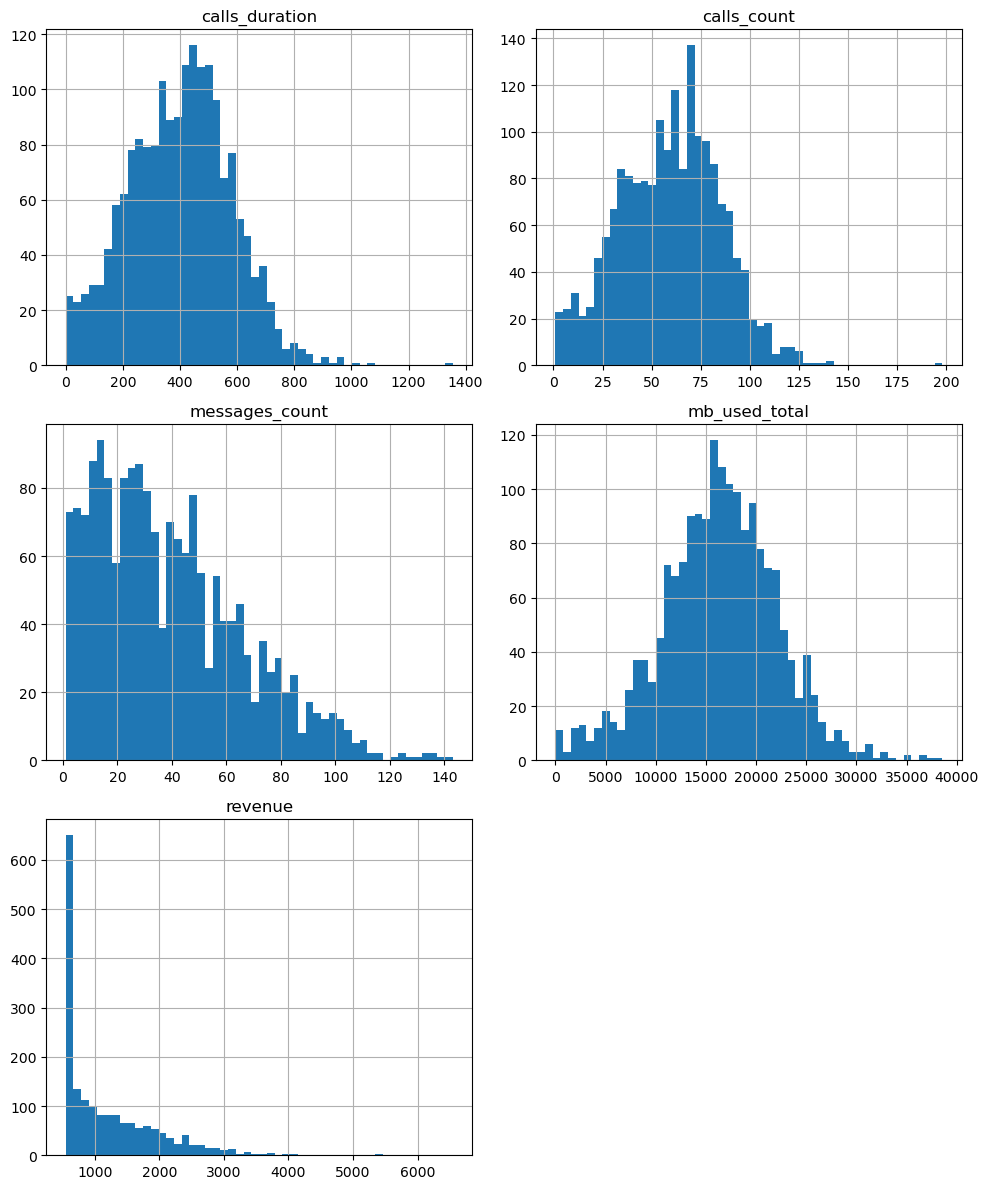

In [7]:
# Гистограммы для тарифа smart
df_user_statistics \
    .loc[df_user_statistics.tariff == 'smart', 
         ['calls_duration', 'calls_count', 'messages_count', 'mb_used_total', 'revenue']] \
    .hist(bins=50, figsize=(10, 12));
plt.tight_layout()

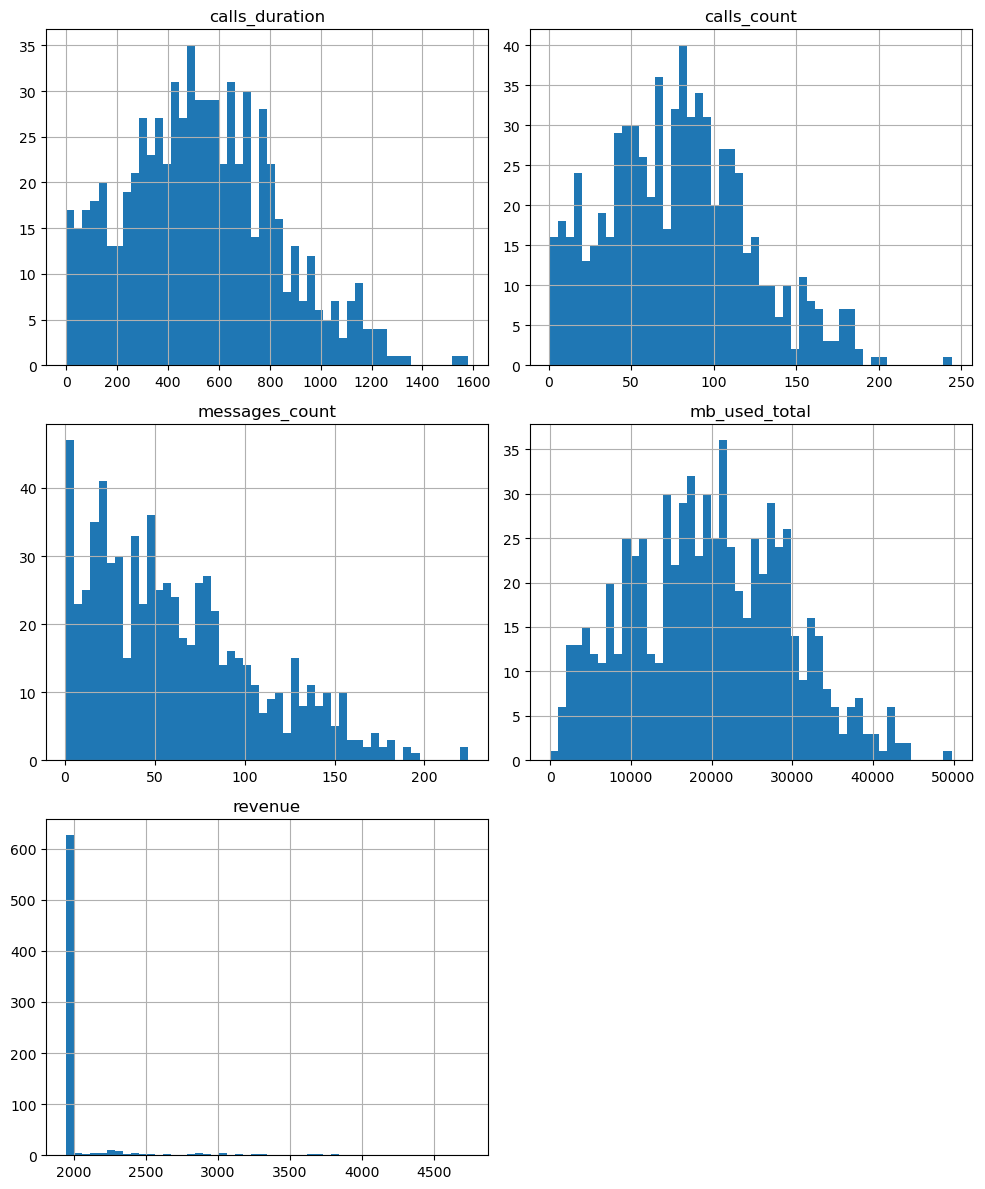

In [8]:
# Гистограммы для тарифа ultra
df_user_statistics \
    .loc[df_user_statistics.tariff == 'ultra', 
         ['calls_duration', 'calls_count', 'messages_count', 'mb_used_total', 'revenue']] \
    .hist(bins=50, figsize=(10, 12));
plt.tight_layout()

Описание распределений.

## Проверка гипотез

Перейдем к проверке гипотез. С точки зрения статистики, первая гипотеза может может быть записано как:

> Нулевая гипотеза: средня выручка пользователей тарифов смарт и ультра одинаковая.

> Альтернативная гипотеза: средняя выручка пользователей таривов смарт и ультра различается.

Это проверть просто (и мы это уже сделали), т.к. средее для обоих датасетов можно посчитать напрямую. Но в качестве упражнения, интересно, что покажут статистические методы.

In [9]:
# Вычислим среднее по каждой выборке и выведем на экран
print('Средняя выручка в месяц с пользователя на тарифе смарт:', 
      int(df_user_statistics[df_user_statistics.tariff == 'smart'].revenue.mean()))
print('Средняя выручка в месяц с пользователя на тарифе ультра:', 
      int(df_user_statistics[df_user_statistics.tariff == 'ultra'].revenue.mean()))

Средняя выручка в месяц с пользователя на тарифе смарт: 1204
Средняя выручка в месяц с пользователя на тарифе ультра: 2040


In [10]:
# То же самое но с помощью scipy.
# t-тест
results = st.ttest_ind(
    df_user_statistics[df_user_statistics.tariff == 'smart'].revenue, 
    df_user_statistics[df_user_statistics.tariff == 'ultra'].revenue)

print('p-значение:', round(results.pvalue, 3))

if results.pvalue < .05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Средняя выручка действительно сильно разная. Альтернативная гипотеза подтверждена.

Посмотрим теперь на вторую гипотезу. Ее можно записать:

> Нулевая гипотеза: средняя выручка пользователей из Москвы и других регионов одинаковая.

> Альтернативная гипотеза: средняя выручка пользователей из Москвы и других регионов разная.

Эту гипотезу тоже можно проверить напрямую: датасеты достаточно маленькие. Но чтобы удволетворить любопытсво, проверим ее статистическими методами тоже.

In [11]:
# Вычислим среднее по каждой выборке и выведем на экран
print('Средняя выручка в месяц с пользователя в Москве:', 
      int(df_user_statistics[df_user_statistics.city == 'Москва'].revenue.mean()))
print('Средняя выручка в месяц с пользователя не в Москве:', 
      int(df_user_statistics[df_user_statistics.city != 'Москва'].revenue.mean()))

Средняя выручка в месяц с пользователя в Москве: 1506
Средняя выручка в месяц с пользователя не в Москве: 1424


In [12]:
# То же самое но с помощью scipy.
# t-тест
results = st.ttest_ind(
    df_user_statistics[df_user_statistics.city == 'Москва'].revenue, 
    df_user_statistics[df_user_statistics.city != 'Москва'].revenue)

print('p-значение:', round(results.pvalue, 3))

if results.pvalue < .05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.038
Отвергаем нулевую гипотезу


Здесь средняя выручка тоже разная, хотя разница не такая существенная, как в предыдушем упражнении. Т-тест показывает это ярче: p-value совсем недалеко от границы в 5%. Тем не менее, выручка разная, альтернативная гипотеза подтверждена.

## Выводы

В этом проекте больший фокус был сделан на приготовление датасета для приключений и проверки гипотез. Методами `merge` `pivot_table` мы сначала свели данные из 4 разных таблиц в одну. Хотя data models в Экселе пользволяют делать то же самое быстрее (и без потери гранулярности), решение получилось довольно безболезненное.

Проверка обоих гипотез оказалось также относительно простой: датасеты достаточно малы, чтобы вычислить средние напрямую. Но было интересно применить статистические методы. Так, в первой гипотезе, средние получились сильно (почти на 50%) разные и p-value было много меньше 1%. Во второй гипотезе среднее достаточно близко друг к другу и p-value получилось почти на границе статистической значимости `alpha`. Если бы мы выбрали `alpha` менее, чем 5%, то результаты могли бы быть совершенно другими.

Это показывает, что во время сереьезных вычислений, надо хорошо понимать, что за данные анализируем и какую статистическую значимость выбираем.